# Speaker Similarity

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/diarization-speaker-similarity](https://github.com/huseinzol05/malaya-speech/tree/master/example/diarization-speaker-similarity).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

### What is Speaker Diarization

In one audio sample, we want to know the timestamp for multiple speakers.

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
from malaya_speech import Pipeline
import malaya_speech
import numpy as np
import matplotlib.pyplot as plt

`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


### load Speaker Vector

So to know speakers similarity, we can use speaker vector, read more about malaya-speech Speaker Vector at https://malaya-speech.readthedocs.io/en/latest/load-speaker-vector.html

In [3]:
model = malaya_speech.speaker_vector.nemo(model = 'huseinzol05/nemo-titanet_large')

In [14]:
_ = model.eval()

### Load audio sample

In [4]:
y, sr = malaya_speech.load('speech/video/The-Singaporean-White-Boy.wav')
len(y), sr

(1634237, 16000)

In [5]:
# just going to take 60 seconds
y = y[:sr * 60]

This audio extracted from https://www.youtube.com/watch?v=HylaY5e1awo&t=2s

In [6]:
# import IPython.display as ipd

# ipd.Audio(y, rate = sr)

### Load VAD

We need to use VAD module to know which parts of the audio sample are speaker activities, read more about VAD at https://malaya-speech.readthedocs.io/en/latest/load-vad.html

In [7]:
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2')

2023-02-19 19:33:13.166314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 19:33:13.172040: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-19 19:33:13.172063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: husein-MS-7D31
2023-02-19 19:33:13.172067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: husein-MS-7D31
2023-02-19 19:33:13.172136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-02-19 19:33:13.172154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported vers

In [8]:
frames = list(malaya_speech.utils.generator.frames(y, 30, sr))

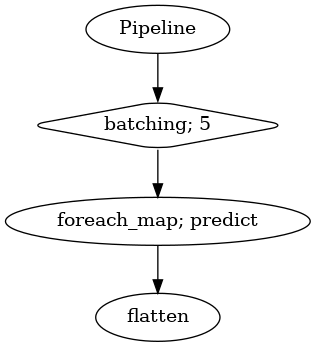

In [9]:
p = Pipeline()
pipeline = (
    p.batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
p.visualize()

In [10]:
%%time

result = p(frames)
result.keys()

/home/husein/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=480
  warnings.warn(


CPU times: user 46.9 s, sys: 1.68 s, total: 48.6 s
Wall time: 6.09 s


dict_keys(['batching', 'predict', 'flatten'])

In [11]:
frames_vad = [(frame, result['flatten'][no]) for no, frame in enumerate(frames)]
grouped_vad = malaya_speech.utils.group.group_frames(frames_vad)
grouped_vad = malaya_speech.utils.group.group_frames_threshold(grouped_vad, threshold_to_stop = 0.3)

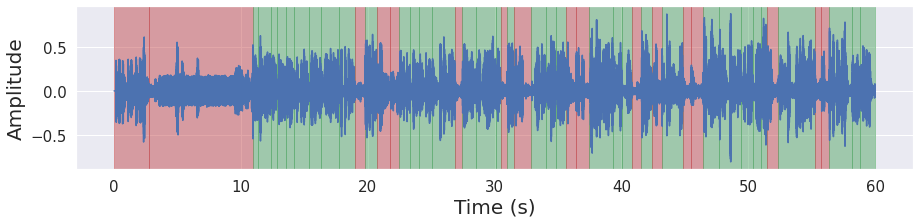

In [12]:
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, figsize = (15, 3))

### Speaker Similarity

Simplest technique, calculate similarity,

```python
def speaker_similarity(
    vad_results,
    speaker_vector,
    similarity_threshold: float = 0.8,
    agg_function: Callable = np.mean,
    return_embedding: bool = False,
):
    """
    Speaker diarization using L2-Norm similarity.

    Parameters
    ----------
    vad_results: List[Tuple[Frame, label]]
        results from VAD.
    speaker_vector: callable
        speaker vector object.
    similarity_threshold: float, optional (default=0.8)
        if current voice activity sample similar at least 0.8, we assumed it is from the same speaker.

    Returns
    -------
    result : List[Tuple[Frame, label]]
    """
```

In [17]:
result_diarization = malaya_speech.diarization.speaker_similarity(grouped_vad, model,
                                                                           similarity_threshold = 0.6)
result_diarization[:5]

[(<malaya_speech.model.frame.Frame at 0x7f6c8ae78a60>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x7f6c8f055640>, 'not a speaker'),
 (<malaya_speech.model.frame.Frame at 0x7f6b0c192550>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x7f6b1c244c40>, 'speaker 0'),
 (<malaya_speech.model.frame.Frame at 0x7f6b0c1a4be0>, 'speaker 0')]

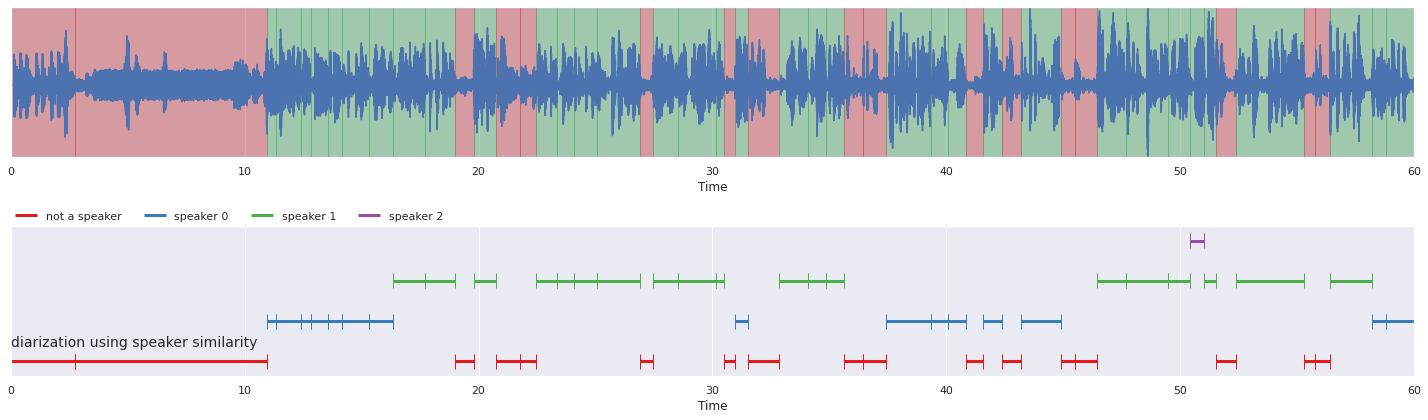

In [18]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(20)
fig.set_figheight(nrows * 3)
malaya_speech.extra.visualization.visualize_vad(y, grouped_vad, sr, ax = ax[0])
malaya_speech.extra.visualization.plot_classification(result_diarization, 
                                                      'diarization using speaker similarity', ax = ax[1],
                                                     x_text = 0.01)
fig.tight_layout()
plt.show()

Problem with speaker similarity, speaker vector models are not really consistent, definition of similarity is ambigious among models, 90% similarity from model A might not be same as model B.